# Main Notebook

File to perform experiments

## Imports

In [4]:
import os
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm
import tensorflow as tf

from models.GaussianProcess import GaussianProcess
from acquisition_functions.UseMO import usemo_acq
from acquisition_functions.MES import mes_acq, basic_mes_acq
from acquisition_functions.PESMO import pesmo_acq
from acquisition_functions.MESMO import mesmo_acq
from arguments.arguments import MainArguments

from MOObenchmark import MOOackley, MOOexponential, MOOquadratic_ackley, MOOnnHousesRegression
from utils.calc_pareto import get_pareto_undominated_by, getSetfromFront

from models.MOOEvaluationProblem import MOOEvaluationProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_termination
from pymoo.optimize import minimize

2023-01-31 18:27:03.559244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 18:27:03.559616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 18:27:03.585292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 18:27:03.585682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 18:27:03.586021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

## Algorithm Arguments

In [5]:
d = 1 # input dimensions
    
seed = 1
np.random.seed(seed)


## iterations of the main algorithm
total_iter = 40
## iterations taken randomly at the beggining
initial_iter = 1

## bound of the inputs definition
### with the current implementations all the input dimensions must have the same bounds, 
### but this can be changed
lower_bound = 0.0000000001
upper_bound = 0.5

lowerBounds = [lower_bound]*d
upperBounds = [upper_bound]*d


## Evaluation

In [3]:
## Evaluation function definition
O = 2
C = 0

def evaluation(x):
    return MOOnnHousesRegression(x)

This cell below gets the real pareto in two ways: with a grid and with a cheap optimizer (genetic algorithm) and plots both of them. These results are used in test problems as the actual pareto front. Although, to obtain these paretos many evaluations of the function are needed, so it has no sense running it in a costly black box problem.

In addition this is only prepared to plot a d=1, O=2 problem. We could visualize any problem, but the visualization get a lot more abstract and more plots are needed. If this is interesting I could do it.

Therefore I set the code below as text.

N = 1_001
X = np.linspace(lower_bound,upper_bound,N)
Z = np.zeros((N,2))

problem = MOOEvaluationProblem(evaluation, O=O, d=d, lowerBounds=lower_bound, upperBounds=upper_bound)
algorithm = NSGA2()
res = minimize( problem, 
                algorithm,
                termination = get_termination("n_gen",100))

real_pareto = res.F[np.argsort(res.F[:,0])]

for i in range(N):
    Z[i]=evaluation(X[i])

fig, axs = plt.subplots(1,3, figsize=(15,4))

axs[0].plot(X, Z[:,0], 'b')
axs[0].plot(X, Z[:,1], 'k')
axs[0].plot(res.X, res.F[:,0], 'xr', markersize=5)
axs[0].plot(res.X, res.F[:,1], 'xr', markersize=5)

axs[1].plot(np.reshape(Z,(-1,2))[:,0], np.reshape(Z,(-1,2))[:,1], 'kx')
axs[1].plot(res.F[:,0], res.F[:,1], 'rx')
res
axs[2].plot(res.F[:,0], res.F[:,1], 'x')
plt.show()

In [4]:
def random_acq(GP: GaussianProcess, **kwargs):
    while True:
        x_rand = np.random.uniform(GP.lowerBounds, GP.upperBounds, GP.d)
        if GP.X is None or not x_rand in GP.X:
            break
    return x_rand, 0

## N experiments

In [13]:
savename = "MOONNHouses"

### GPs Initialization
GP = GaussianProcess(O, C, d, lowerBounds, upperBounds, noise_variance=2e-6)

#### Initial samples, at least 1
for l in range(initial_iter):
    ## Get random evaluation point
    while True:
        x_rand = np.random.uniform(lowerBounds[0], upperBounds[0], d)
        if GP.X is None or not x_rand in GP.X:
            break
    ## EVALUATION OF THE OUTSIDE FUNCTION
    
    y_rand = evaluation(x_rand)
    GP.addSample(x_rand,y_rand)

GP.updateGP()
GP.optimizeKernel()
if False:
    GP.plotSamples()

for l in range(total_iter):

    ## For all acq functions but usemo
    #x_best, acq_best = mes_acq(GP)
    ## For usemo
    x_best, acq_best = usemo_acq(GP, function = "ei", showplots = False)

    ## EVALUATION OF THE OUTSIDE FUNCTION
    y_best = evaluation(x_best)

    ## UPDATE
    GP.addSample(x_best,y_best)     ## Add new sample to the model
    GP.updateGP()                   ## Update data on the GP regressor
    GP.optimizeKernel()             ## Optimize kernel hyperparameters

    print("Iteration=", l, " x_best=", x_best, "y=", y_best)
    GP.plot()
    

C = [0.06225116]
Epoch 1/6
52/52 [==============================] - 0s 3ms/step - loss: 18571274240.0000 - mae: 420245.6875 - mse: 298321379328.0000 - val_loss: 5841217536.0000 - val_mae: 232186.5781 - val_mse: 93829332992.0000
Epoch 2/6
52/52 [==============================] - 0s 2ms/step - loss: 7205971456.0000 - mae: 226927.2969 - mse: 115752787968.0000 - val_loss: 4863506432.0000 - val_mae: 201771.3750 - val_mse: 78123917312.0000
Epoch 3/6
52/52 [==============================] - 0s 2ms/step - loss: 6851494400.0000 - mae: 225145.2812 - mse: 110058479616.0000 - val_loss: 4760005120.0000 - val_mae: 198626.5938 - val_mse: 76461334528.0000
Epoch 4/6
52/52 [==============================] - 0s 2ms/step - loss: 6650344960.0000 - mae: 221760.7812 - mse: 106827325440.0000 - val_loss: 4508368896.0000 - val_mae: 194241.6719 - val_mse: 72419131392.0000
Epoch 5/6
52/52 [==============================] - 0s 2ms/step - loss: 6432984064.0000 - mae: 216737.6094 - mse: 103335690240.0000 - val_loss:

InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/triangular_solve/MatrixTriangularSolve' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1099181/16118900.py", line 36, in <module>
      GP.optimizeKernel()             ## Optimize kernel hyperparameters
    File "/home/mtm/MOOEasyTool/models/GaussianProcess.py", line 52, in optimizeKernel
      self.multiGPR.optimizeKernel()
    File "/home/mtm/MOOEasyTool/models/GaussianProcess.py", line 457, in optimizeKernel
      self.opt.minimize(
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 95, in minimize
      return scipy.optimize.minimize(
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_minimize.py", line 681, in minimize
      res = _minimize_lbfgsb(fun, x0, args, jac, bounds,
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_lbfgsb_py.py", line 308, in _minimize_lbfgsb
      sf = _prepare_scalar_function(fun, x0, jac=jac, args=args, epsilon=eps,
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 263, in _prepare_scalar_function
      sf = ScalarFunction(fun, x0, args, grad, hess,
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 158, in __init__
      self._update_fun()
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 251, in _update_fun
      self._update_fun_impl()
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 155, in update_fun
      self.f = fun_wrapped(self.x)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
      fx = fun(np.copy(x), *args)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 76, in __call__
      self._compute_if_needed(x, *args)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/scipy/optimize/_optimize.py", line 70, in _compute_if_needed
      fg = self.fun(x, *args)
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 137, in _eval
      loss, grad = _tf_eval(tf.convert_to_tensor(x))
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 119, in _tf_eval
      if first_call:
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 121, in _tf_eval
      loss, grads = _compute_loss_and_gradients(
    File "/home/mtm/MOOEasyTool/venvMOO/lib/python3.8/site-packages/gpflow/optimizers/scipy.py", line 225, in _compute_loss_and_gradients
      grads = tape.gradient(loss, variables, unconnected_gradients=unconnected_gradients)
Node: 'gradient_tape/triangular_solve/MatrixTriangularSolve'
Input matrix is not invertible.
	 [[{{node gradient_tape/triangular_solve/MatrixTriangularSolve}}]] [Op:__inference__tf_eval_486436]

## Evaluate results

As you are doing a real world experiment you do not have access to the real pareto front, then you fo noy hsbr yhr metrics as before (I removed them).

What you should evaluate is the results in terms of the best *y* possible. You have the data below, but you may do a pandas dataframe to store it cleaner when it is computed in the previous section.

GP.X === samples where the function was evaluated

GP.Y === results of those evaluations

In [ ]:
GP.X, GP.Y

In [ ]:
plt.scatter(-GP.Y[:,0],-GP.Y[:,1])

In [ ]:
GP.Y

In [9]:
mkdir Checkpoints_new

In [ ]:
results = []
front = []

for c in np.linspace(0,10,100):
    for i in np.flip(np.linspace(0,0.99999999999,100)):
        checkpoint_path = f"./Checkpoints_new/model_{c}_{i}"
        print("########################################")
        print("Iteration: ", len(results) + 1)

        result = [(c,i), MOOnnHousesRegression((c,i))]
        results.append(result)
        front_check = get_pareto_undominated_by(result[1][0].reshape((1,2)), front)
        if len(front_check) != 0:
            if len(front) == 0:
                front.append(front_check[0])
                front = np.array(front)
            else:
                result[1][1].save_weights(checkpoint_path)
                front = np.vstack([front, front_check[0]])



########################################
Iteration:  1
C = (0.0, 0.99999999999)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 197618.7188 - mae: 197275.8438 - mse: 111481741312.0000 - val_loss: 169314.5469 - val_mae: 168873.4531 - val_mse: 76654108672.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 158766.2344 - mae: 158305.0781 - mse: 67438854144.0000 - val_loss: 174473.1562 - val_mae: 174003.1250 - val_mse: 81474584576.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 155931.1406 - mae: 155452.5469 - mse: 63660343296.0000 - val_loss: 155228.6719 - val_mae: 154747.0156 - val_mse: 63919083520.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 154522.2500 - mae: 154040.3594 - mse: 61429972992.0000 - val_loss: 156131.1406 - val_mae: 155644.3750 - val_mse: 55208566784.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 153974.2969 - mae: 153484.9062 - m

517/517 [==============================] - 1s 2ms/step - loss: 158504.9375 - mae: 158073.0625 - mse: 67365650432.0000 - val_loss: 152782.0312 - val_mae: 152340.3281 - val_mse: 59921690624.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 155970.2500 - mae: 155521.2188 - mse: 65071517696.0000 - val_loss: 157649.7031 - val_mae: 157200.2656 - val_mse: 65884909568.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 155354.4844 - mae: 154902.2812 - mse: 63312846848.0000 - val_loss: 159975.6562 - val_mae: 159517.5469 - val_mse: 69290786816.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 155079.9219 - mae: 154618.2969 - mse: 62649573376.0000 - val_loss: 150527.9062 - val_mae: 150061.4375 - val_mse: 58661765120.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 153396.9375 - mae: 152928.1094 - mse: 60679761920.0000 - val_loss: 151749.8438 - val_mae: 151282.3750 - val_mse: 56070000640.

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 154201.3281 - mae: 153861.3750 - mse: 61474430976.0000 - val_loss: 151108.9844 - val_mae: 150764.0469 - val_mse: 58952134656.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 154195.7969 - mae: 153846.0000 - mse: 61508771840.0000 - val_loss: 151021.1250 - val_mae: 150660.9219 - val_mse: 55961346048.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 153615.5625 - mae: 153253.8906 - mse: 60838596608.0000 - val_loss: 151199.4844 - val_mae: 150828.8594 - val_mse: 59259928576.0000
########################################
Iteration:  14
C = (0.0, 0.8686868686781818)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 199312.3125 - mae: 199021.9375 - mse: 112463036416.0000 - val_loss: 161860.5781 - val_mae: 161482.9062 - val_mse: 71072587776.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 158327.0156 - mae: 157937.32

Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 153719.3594 - mae: 153320.6562 - mse: 60932538368.0000 - val_loss: 152373.1250 - val_mae: 151975.0469 - val_mse: 57113743360.0000
########################################
Iteration:  20
C = (0.0, 0.8080808080727273)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 264397.3125 - mae: 264216.8438 - mse: 171938430976.0000 - val_loss: 161514.7656 - val_mae: 161234.0781 - val_mse: 67153424384.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 159600.5000 - mae: 159300.4531 - mse: 67037609984.0000 - val_loss: 154401.4844 - val_mae: 154085.8594 - val_mse: 62762913792.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 156597.2969 - mae: 156270.4375 - mse: 63888150528.0000 - val_loss: 156313.0625 - val_mae: 155977.2188 - val_mse: 57688817664.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 155062.8438 - mae: 154720.78

517/517 [==============================] - 1s 2ms/step - loss: 198866.8125 - mae: 198616.2500 - mse: 113379975168.0000 - val_loss: 159307.5156 - val_mae: 158977.0625 - val_mse: 68755243008.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 159419.6250 - mae: 159074.7656 - mse: 68034588672.0000 - val_loss: 157130.9219 - val_mae: 156777.4688 - val_mse: 58974715904.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 155619.2500 - mae: 155261.6250 - mse: 63956447232.0000 - val_loss: 153567.7188 - val_mae: 153205.7812 - val_mse: 58198179840.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 155151.5156 - mae: 154786.3906 - mse: 62806474752.0000 - val_loss: 151745.8281 - val_mae: 151374.2969 - val_mse: 56085336064.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 153844.0781 - mae: 153470.8906 - mse: 61564973056.0000 - val_loss: 151876.0469 - val_mae: 151500.4844 - val_mse: 60726988800

Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 156019.6562 - mae: 155696.1875 - mse: 63200403456.0000 - val_loss: 151873.5312 - val_mae: 151545.2500 - val_mse: 59252555776.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 154561.1406 - mae: 154228.1406 - mse: 62082641920.0000 - val_loss: 150332.4844 - val_mae: 149995.9688 - val_mse: 56717914112.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 154347.2188 - mae: 154006.7812 - mse: 61286215680.0000 - val_loss: 152370.3281 - val_mae: 152027.9062 - val_mse: 57756192768.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 153486.8594 - mae: 153140.5625 - mse: 60101136384.0000 - val_loss: 151138.2031 - val_mae: 150784.2500 - val_mse: 55134957568.0000
########################################
Iteration:  33
C = (0.0, 0.6767676767609091)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 193524.0938 - mae: 193298.578

Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 154890.1250 - mae: 154574.9688 - mse: 61587226624.0000 - val_loss: 151571.0156 - val_mae: 151254.8594 - val_mse: 60453847040.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 153336.2188 - mae: 153015.9219 - mse: 60879556608.0000 - val_loss: 149435.6406 - val_mae: 149112.1719 - val_mse: 57615876096.0000
########################################
Iteration:  39
C = (0.0, 0.6161616161554545)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 200468.7969 - mae: 200254.2031 - mse: 116647886848.0000 - val_loss: 160271.9375 - val_mae: 159983.8750 - val_mse: 70004088832.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 159075.6562 - mae: 158774.4062 - mse: 67540807680.0000 - val_loss: 156492.2812 - val_mae: 156176.5156 - val_mse: 66433003520.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 155851.6250 - mae: 155531.53

########################################
Iteration:  45
C = (0.0, 0.55555555555)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 198023.4062 - mae: 197826.5312 - mse: 113593524224.0000 - val_loss: 156555.9375 - val_mae: 156305.0469 - val_mse: 65943334912.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 158348.5000 - mae: 158085.9688 - mse: 66687442944.0000 - val_loss: 152036.6719 - val_mae: 151768.0312 - val_mse: 59901509632.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 155670.3438 - mae: 155395.2656 - mse: 63888936960.0000 - val_loss: 151860.7031 - val_mae: 151584.1406 - val_mse: 60069777408.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 154394.4531 - mae: 154116.1250 - mse: 61402480640.0000 - val_loss: 151677.7344 - val_mae: 151397.2031 - val_mse: 58088243200.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 154066.6875 - mae: 153784.0000 - 

517/517 [==============================] - 1s 2ms/step - loss: 160355.5781 - mae: 160171.8594 - mse: 67484672000.0000 - val_loss: 155919.2031 - val_mae: 155724.7188 - val_mse: 59073462272.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 156970.2031 - mae: 156770.1250 - mse: 64367075328.0000 - val_loss: 152661.3281 - val_mae: 152453.6875 - val_mse: 57366339584.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 154066.2969 - mae: 153854.4688 - mse: 61488357376.0000 - val_loss: 150587.9375 - val_mae: 150370.5781 - val_mse: 58094469120.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 153631.7500 - mae: 153409.7969 - mse: 60181684224.0000 - val_loss: 150468.3906 - val_mae: 150241.5000 - val_mse: 56305381376.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 152692.6562 - mae: 152463.7500 - mse: 59457134592.0000 - val_loss: 153532.8750 - val_mae: 153299.9375 - val_mse: 55845523456.

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 154577.9062 - mae: 154345.3438 - mse: 62012436480.0000 - val_loss: 155669.9375 - val_mae: 155433.9688 - val_mse: 64586387456.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 153692.7188 - mae: 153453.5469 - mse: 61704810496.0000 - val_loss: 157890.7812 - val_mae: 157649.3750 - val_mse: 56972775424.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 153559.7500 - mae: 153315.4531 - mse: 60769587200.0000 - val_loss: 150144.5156 - val_mae: 149899.2656 - val_mse: 59309182976.0000
########################################
Iteration:  58
C = (0.0, 0.4242424242381818)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 198686.2188 - mae: 198531.3125 - mse: 113148592128.0000 - val_loss: 158399.0469 - val_mae: 158199.4062 - val_mse: 66661220352.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 158164.1406 - mae: 157954.79

Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 153034.8438 - mae: 152849.5156 - mse: 60446826496.0000 - val_loss: 153847.6406 - val_mae: 153659.6406 - val_mse: 59339333632.0000
########################################
Iteration:  64
C = (0.0, 0.3636363636327273)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 195242.9062 - mae: 195111.1875 - mse: 109528416256.0000 - val_loss: 161840.2344 - val_mae: 161669.2188 - val_mse: 64363126784.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 158106.7500 - mae: 157929.3750 - mse: 67228188672.0000 - val_loss: 154366.2656 - val_mae: 154184.7344 - val_mse: 64681320448.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 155470.6875 - mae: 155286.1875 - mse: 64387211264.0000 - val_loss: 153738.4531 - val_mae: 153552.4531 - val_mse: 62869426176.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 154851.6875 - mae: 154663.75

517/517 [==============================] - 1s 2ms/step - loss: 196957.8594 - mae: 196847.1250 - mse: 109216907264.0000 - val_loss: 168227.7344 - val_mae: 168086.7344 - val_mse: 77288669184.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 157291.6250 - mae: 157142.5469 - mse: 65774764032.0000 - val_loss: 152441.5469 - val_mae: 152286.9688 - val_mse: 57957376000.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 156020.4688 - mae: 155862.6250 - mse: 63751553024.0000 - val_loss: 154463.1875 - val_mae: 154302.7031 - val_mse: 64252547072.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 153742.0625 - mae: 153580.0000 - mse: 61849755648.0000 - val_loss: 154221.2656 - val_mae: 154056.0312 - val_mse: 62939025408.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 153162.4375 - mae: 152996.1719 - mse: 60732657664.0000 - val_loss: 151596.6406 - val_mae: 151427.6094 - val_mse: 60223938560

Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 156240.7656 - mae: 156105.7344 - mse: 63971807232.0000 - val_loss: 153849.3750 - val_mae: 153711.2969 - val_mse: 58240798720.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 154405.1875 - mae: 154265.1406 - mse: 61943046144.0000 - val_loss: 153256.0312 - val_mae: 153113.4844 - val_mse: 61082820608.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 153723.4531 - mae: 153578.2969 - mse: 60706971648.0000 - val_loss: 148828.3750 - val_mae: 148680.5312 - val_mse: 54092779520.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 152373.3438 - mae: 152222.9062 - mse: 59751182336.0000 - val_loss: 149776.9531 - val_mae: 149625.7812 - val_mse: 58471886848.0000
########################################
Iteration:  77
C = (0.0, 0.2323232323209091)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 200295.7812 - mae: 200207.796

Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 153738.1094 - mae: 153635.6094 - mse: 61446074368.0000 - val_loss: 150682.2812 - val_mae: 150578.0469 - val_mse: 59000180736.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 153254.5625 - mae: 153148.7031 - mse: 60448751616.0000 - val_loss: 152358.2344 - val_mae: 152250.6875 - val_mse: 62101590016.0000
########################################
Iteration:  83
C = (0.0, 0.17171717171545453)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 200249.5781 - mae: 200185.5938 - mse: 114169176064.0000 - val_loss: 159425.8750 - val_mae: 159342.4688 - val_mse: 71240523776.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 157537.8906 - mae: 157448.7500 - mse: 66811248640.0000 - val_loss: 152235.5312 - val_mae: 152142.4844 - val_mse: 60909838336.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 155045.0938 - mae: 154950.2

########################################
Iteration:  89
C = (0.0, 0.11111111111)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 199135.3281 - mae: 199090.4219 - mse: 115208273920.0000 - val_loss: 158593.7188 - val_mae: 158535.7969 - val_mse: 69244264448.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 157883.1562 - mae: 157820.9688 - mse: 67110649856.0000 - val_loss: 153133.3906 - val_mae: 153067.9844 - val_mse: 61260763136.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 155275.4688 - mae: 155208.0000 - mse: 63503716352.0000 - val_loss: 151363.7969 - val_mae: 151293.7344 - val_mse: 57533014016.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 154532.2812 - mae: 154461.5469 - mse: 62065881088.0000 - val_loss: 150592.7188 - val_mae: 150519.8438 - val_mse: 55241732096.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 153896.0156 - mae: 153821.6562 - 

517/517 [==============================] - 1s 2ms/step - loss: 159562.2031 - mae: 159532.0312 - mse: 67474464768.0000 - val_loss: 154643.5938 - val_mae: 154611.3438 - val_mse: 63596101632.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 155035.4844 - mae: 155001.2812 - mse: 63314329600.0000 - val_loss: 157118.7188 - val_mae: 157082.3594 - val_mse: 65308721152.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 154184.7656 - mae: 154146.8750 - mse: 62210818048.0000 - val_loss: 149922.7031 - val_mae: 149883.4219 - val_mse: 57622732800.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 153539.3750 - mae: 153498.9375 - mse: 60939223040.0000 - val_loss: 152346.0469 - val_mae: 152303.8281 - val_mse: 61700333568.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 152787.4844 - mae: 152743.8594 - mse: 60366577664.0000 - val_loss: 148917.4219 - val_mae: 148872.2969 - val_mse: 56630370304.

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5884694016.0000 - mae: 161166.0938 - mse: 58256834560.0000 - val_loss: 7146072064.0000 - val_mae: 188634.1406 - val_mse: 70744211456.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5809927168.0000 - mae: 159446.0781 - mse: 57516699648.0000 - val_loss: 5579888640.0000 - val_mae: 159300.6719 - val_mse: 55239323648.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5808708608.0000 - mae: 160172.7969 - mse: 57504604160.0000 - val_loss: 5681270784.0000 - val_mae: 153273.0312 - val_mse: 56243040256.0000
########################################
Iteration:  102
C = (0.10101010101010101, 0.9898989898890909)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 10730622976.0000 - mae: 206007.7812 - mse: 106231119872.0000 - val_loss: 6692346880.0000 - val_mae: 165890.6562 - val_mse: 66252587008.0000
Epoch 2/6
517/517 [==============================] 

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5836094976.0000 - mae: 160471.7500 - mse: 57775722496.0000 - val_loss: 5484401152.0000 - val_mae: 152149.5938 - val_mse: 54294044672.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5807391232.0000 - mae: 159310.6250 - mse: 57491582976.0000 - val_loss: 6021120512.0000 - val_mae: 157107.2344 - val_mse: 59607511040.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5774978560.0000 - mae: 158896.2500 - mse: 57170731008.0000 - val_loss: 5422361088.0000 - val_mae: 156578.9531 - val_mse: 53679800320.0000
########################################
Iteration:  108
C = (0.10101010101010101, 0.9292929292836364)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 10915247104.0000 - mae: 209413.7031 - mse: 108058910720.0000 - val_loss: 7688780288.0000 - val_mae: 176474.3125 - val_mse: 76117180416.0000
Epoch 2/6
517/517 [==============================] 

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5824866304.0000 - mae: 158080.6094 - mse: 57664614400.0000 - val_loss: 5406639616.0000 - val_mae: 150914.6250 - val_mse: 53524217856.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5782948352.0000 - mae: 158583.5625 - mse: 57249599488.0000 - val_loss: 5423775744.0000 - val_mae: 153317.6562 - val_mse: 53693837312.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5671873536.0000 - mae: 156028.0156 - mse: 56150024192.0000 - val_loss: 5999758336.0000 - val_mae: 173399.7500 - val_mse: 59395854336.0000
########################################
Iteration:  114
C = (0.10101010101010101, 0.8686868686781818)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 10161126400.0000 - mae: 202154.4844 - mse: 100593147904.0000 - val_loss: 5979032064.0000 - val_mae: 159437.0469 - val_mse: 59190833152.0000
Epoch 2/6
517/517 [==============================] 

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5935151104.0000 - mae: 161960.6250 - mse: 58756403200.0000 - val_loss: 5627072512.0000 - val_mae: 162258.9531 - val_mse: 55706406912.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5917562368.0000 - mae: 161469.7656 - mse: 58582237184.0000 - val_loss: 5560789504.0000 - val_mae: 154137.6875 - val_mse: 55050264576.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5870834176.0000 - mae: 161372.2344 - mse: 58119659520.0000 - val_loss: 5849266176.0000 - val_mae: 170147.1094 - val_mse: 57906036736.0000
########################################
Iteration:  120
C = (0.10101010101010101, 0.8080808080727273)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 10486241280.0000 - mae: 206386.3594 - mse: 103811694592.0000 - val_loss: 6575629312.0000 - val_mae: 165540.4688 - val_mse: 65097080832.0000
Epoch 2/6
517/517 [==============================] 

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5960710656.0000 - mae: 161982.1719 - mse: 59009376256.0000 - val_loss: 5571588608.0000 - val_mae: 157997.4844 - val_mse: 55157137408.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5935436800.0000 - mae: 161880.9219 - mse: 58759213056.0000 - val_loss: 5596957184.0000 - val_mae: 162183.2656 - val_mse: 55408267264.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5868542976.0000 - mae: 160715.1719 - mse: 58096955392.0000 - val_loss: 5709361152.0000 - val_mae: 155371.8906 - val_mse: 56521134080.0000
########################################
Iteration:  126
C = (0.10101010101010101, 0.7474747474672727)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 11745489920.0000 - mae: 216686.3125 - mse: 116278222848.0000 - val_loss: 6034905600.0000 - val_mae: 160306.4844 - val_mse: 59743965184.0000
Epoch 2/6
517/517 [==============================] 

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5875995136.0000 - mae: 160838.5312 - mse: 58170781696.0000 - val_loss: 5576633856.0000 - val_mae: 158185.2500 - val_mse: 55207092224.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5853043712.0000 - mae: 160516.3906 - mse: 57943572480.0000 - val_loss: 5536742912.0000 - val_mae: 155662.5781 - val_mse: 54812200960.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5916057600.0000 - mae: 161210.2656 - mse: 58567360512.0000 - val_loss: 5461232640.0000 - val_mae: 155403.8125 - val_mse: 54064648192.0000
########################################
Iteration:  132
C = (0.10101010101010101, 0.6868686868618181)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 11381715968.0000 - mae: 213472.7344 - mse: 112676872192.0000 - val_loss: 6024051712.0000 - val_mae: 167451.8750 - val_mse: 59636424704.0000
Epoch 2/6
517/517 [==============================] 

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5930338304.0000 - mae: 161848.3125 - mse: 58708787200.0000 - val_loss: 5672398336.0000 - val_mae: 160844.0938 - val_mse: 56155176960.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5903948288.0000 - mae: 161651.0781 - mse: 58447523840.0000 - val_loss: 5669534208.0000 - val_mae: 159820.1250 - val_mse: 56126803968.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5847445504.0000 - mae: 160861.2031 - mse: 57888096256.0000 - val_loss: 5598765056.0000 - val_mae: 158378.1406 - val_mse: 55426207744.0000
########################################
Iteration:  138
C = (0.10101010101010101, 0.6262626262563636)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 10518656000.0000 - mae: 204047.6875 - mse: 104132689920.0000 - val_loss: 6566510592.0000 - val_mae: 179312.8281 - val_mse: 65006673920.0000
Epoch 2/6
517/517 [==============================] 

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5854089216.0000 - mae: 159576.2500 - mse: 57953886208.0000 - val_loss: 5324098560.0000 - val_mae: 151632.8281 - val_mse: 52707078144.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5800100352.0000 - mae: 158858.0625 - mse: 57419415552.0000 - val_loss: 5404803584.0000 - val_mae: 157664.4844 - val_mse: 53505974272.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5696858112.0000 - mae: 157523.7812 - mse: 56397307904.0000 - val_loss: 5451842560.0000 - val_mae: 159266.1250 - val_mse: 53971664896.0000
########################################
Iteration:  144
C = (0.10101010101010101, 0.565656565650909)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 17609205760.0000 - mae: 277471.8750 - mse: 174328479744.0000 - val_loss: 6949411328.0000 - val_mae: 162077.0156 - val_mse: 68797546496.0000
Epoch 2/6
517/517 [==============================] -

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5808412160.0000 - mae: 158777.0469 - mse: 57501724672.0000 - val_loss: 5678348288.0000 - val_mae: 164526.9062 - val_mse: 56213995520.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5753242624.0000 - mae: 158323.9688 - mse: 56955535360.0000 - val_loss: 5489588224.0000 - val_mae: 160514.2969 - val_mse: 54345334784.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5702357504.0000 - mae: 157416.3750 - mse: 56451768320.0000 - val_loss: 5491665408.0000 - val_mae: 150350.7656 - val_mse: 54365986816.0000
########################################
Iteration:  150
C = (0.10101010101010101, 0.5050505050454546)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 10757158912.0000 - mae: 206225.2969 - mse: 106493878272.0000 - val_loss: 6230508544.0000 - val_mae: 171650.3281 - val_mse: 61680328704.0000
Epoch 2/6
517/517 [==============================] 

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5848918528.0000 - mae: 160798.6875 - mse: 57902739456.0000 - val_loss: 5549755392.0000 - val_mae: 158312.3906 - val_mse: 54941011968.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5834259968.0000 - mae: 159827.7031 - mse: 57757630464.0000 - val_loss: 5639575040.0000 - val_mae: 163588.0000 - val_mse: 55830163456.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5743395840.0000 - mae: 159352.8906 - mse: 56858071040.0000 - val_loss: 5392530944.0000 - val_mae: 157013.4375 - val_mse: 53384499200.0000
########################################
Iteration:  156
C = (0.10101010101010101, 0.44444444444)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 12585178112.0000 - mae: 224906.8281 - mse: 124591005696.0000 - val_loss: 6139097088.0000 - val_mae: 157002.2500 - val_mse: 60775493632.0000
Epoch 2/6
517/517 [==============================] - 1s 

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5827691520.0000 - mae: 159879.5312 - mse: 57692585984.0000 - val_loss: 5631194624.0000 - val_mae: 156760.3438 - val_mse: 55747256320.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5729811968.0000 - mae: 158804.5625 - mse: 56723566592.0000 - val_loss: 5766049280.0000 - val_mae: 166378.6094 - val_mse: 57082228736.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5790354432.0000 - mae: 159019.9062 - mse: 57322909696.0000 - val_loss: 5445593088.0000 - val_mae: 158091.6094 - val_mse: 53909811200.0000
########################################
Iteration:  162
C = (0.10101010101010101, 0.38383838383454544)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 10644593664.0000 - mae: 204804.3906 - mse: 105379463168.0000 - val_loss: 6086739968.0000 - val_mae: 158640.6406 - val_mse: 60257136640.0000
Epoch 2/6
517/517 [==============================]

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5844982784.0000 - mae: 160304.5156 - mse: 57863720960.0000 - val_loss: 5498260480.0000 - val_mae: 155527.2344 - val_mse: 54431227904.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5809313792.0000 - mae: 159222.7344 - mse: 57510621184.0000 - val_loss: 5505996288.0000 - val_mae: 152006.7188 - val_mse: 54507864064.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5685765120.0000 - mae: 158003.8281 - mse: 56287432704.0000 - val_loss: 5957150208.0000 - val_mae: 170222.4062 - val_mse: 58974117888.0000
########################################
Iteration:  168
C = (0.10101010101010101, 0.3232323232290909)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 10956411904.0000 - mae: 207712.1562 - mse: 108466388992.0000 - val_loss: 6390089216.0000 - val_mae: 159006.7188 - val_mse: 63260291072.0000
Epoch 2/6
517/517 [==============================] 

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5826419712.0000 - mae: 158739.0625 - mse: 57679994880.0000 - val_loss: 5669809152.0000 - val_mae: 151338.1719 - val_mse: 56129630208.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5788824064.0000 - mae: 158528.6875 - mse: 57307766784.0000 - val_loss: 5448786944.0000 - val_mae: 158804.3281 - val_mse: 53941424128.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5770674176.0000 - mae: 158237.2656 - mse: 57128087552.0000 - val_loss: 5483283968.0000 - val_mae: 150750.5781 - val_mse: 54283014144.0000
########################################
Iteration:  174
C = (0.10101010101010101, 0.26262626262363636)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 11057309696.0000 - mae: 207149.3281 - mse: 109465378816.0000 - val_loss: 6164931072.0000 - val_mae: 159358.7969 - val_mse: 61031239680.0000
Epoch 2/6
517/517 [==============================]

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5861947392.0000 - mae: 160175.3281 - mse: 58031673344.0000 - val_loss: 5665306624.0000 - val_mae: 163774.9062 - val_mse: 56084922368.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5779368960.0000 - mae: 158930.2656 - mse: 57214160896.0000 - val_loss: 5329237504.0000 - val_mae: 151279.5625 - val_mse: 52757946368.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5697941504.0000 - mae: 157763.7031 - mse: 56408117248.0000 - val_loss: 5516441600.0000 - val_mae: 151302.3281 - val_mse: 54611271680.0000
########################################
Iteration:  180
C = (0.10101010101010101, 0.20202020201818183)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 17137975296.0000 - mae: 274934.2812 - mse: 169663234048.0000 - val_loss: 6154191872.0000 - val_mae: 166298.0156 - val_mse: 60924866560.0000
Epoch 2/6
517/517 [==============================]

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5914226176.0000 - mae: 158882.0469 - mse: 58549268480.0000 - val_loss: 5547251712.0000 - val_mae: 155205.1719 - val_mse: 54916268032.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5877203456.0000 - mae: 159722.5000 - mse: 58182701056.0000 - val_loss: 5353532416.0000 - val_mae: 150700.5000 - val_mse: 52998479872.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5755283968.0000 - mae: 157465.3594 - mse: 56975749120.0000 - val_loss: 6373946880.0000 - val_mae: 165980.0625 - val_mse: 63100424192.0000
########################################
Iteration:  186
C = (0.10101010101010101, 0.14141414141272726)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 10872031232.0000 - mae: 206882.8125 - mse: 107631140864.0000 - val_loss: 6228378112.0000 - val_mae: 168793.3906 - val_mse: 61659275264.0000
Epoch 2/6
517/517 [==============================]

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5850350592.0000 - mae: 159926.5469 - mse: 57916833792.0000 - val_loss: 6005226496.0000 - val_mae: 155645.4531 - val_mse: 59450204160.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5712639488.0000 - mae: 157687.9688 - mse: 56553521152.0000 - val_loss: 5704496128.0000 - val_mae: 162054.4531 - val_mse: 56472915968.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5765085696.0000 - mae: 158057.4375 - mse: 57072762880.0000 - val_loss: 5590251008.0000 - val_mae: 149807.0938 - val_mse: 55342006272.0000
########################################
Iteration:  192
C = (0.10101010101010101, 0.08080808080727273)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 10431406080.0000 - mae: 202578.2969 - mse: 103268933632.0000 - val_loss: 6123901440.0000 - val_mae: 161128.0625 - val_mse: 60625039360.0000
Epoch 2/6
517/517 [==============================]

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 5927548416.0000 - mae: 162087.0781 - mse: 58681143296.0000 - val_loss: 5619644416.0000 - val_mae: 159272.6719 - val_mse: 55632896000.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 5881510912.0000 - mae: 160900.2969 - mse: 58225356800.0000 - val_loss: 5418192896.0000 - val_mae: 153569.3750 - val_mse: 53638594560.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 5801690624.0000 - mae: 159825.8750 - mse: 57435156480.0000 - val_loss: 5481737728.0000 - val_mae: 156413.5938 - val_mse: 54267674624.0000
########################################
Iteration:  198
C = (0.10101010101010101, 0.02020202020181818)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 10469373952.0000 - mae: 204599.8438 - mse: 103644725248.0000 - val_loss: 5973799424.0000 - val_mae: 164001.9375 - val_mse: 59138998272.0000
Epoch 2/6
517/517 [==============================]

Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11527763968.0000 - mae: 158245.4375 - mse: 57061629952.0000 - val_loss: 11603145728.0000 - val_mae: 168972.8594 - val_mse: 57434734592.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11412203520.0000 - mae: 157166.5312 - mse: 56489594880.0000 - val_loss: 11215051776.0000 - val_mae: 164771.1562 - val_mse: 55513686016.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 11317941248.0000 - mae: 157413.0312 - mse: 56022978560.0000 - val_loss: 10761934848.0000 - val_mae: 156599.1875 - val_mse: 53270777856.0000
########################################
Iteration:  204
C = (0.20202020202020202, 0.9696969696872727)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 21540524032.0000 - mae: 205755.5781 - mse: 106624638976.0000 - val_loss: 12713438208.0000 - val_mae: 160484.7500 - val_mse: 62930743296.0000
Epoch 2/6
517/517 [=========================

517/517 [==============================] - 1s 2ms/step - loss: 12326573056.0000 - mae: 164284.6250 - mse: 61015666688.0000 - val_loss: 12065719296.0000 - val_mae: 157835.2031 - val_mse: 59724525568.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 12015872000.0000 - mae: 162928.7031 - mse: 59477741568.0000 - val_loss: 11671582720.0000 - val_mae: 153933.0781 - val_mse: 57773535232.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11687382016.0000 - mae: 160215.5938 - mse: 57851727872.0000 - val_loss: 12546967552.0000 - val_mae: 159767.4062 - val_mse: 62106701824.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 11703878656.0000 - mae: 160378.4375 - mse: 57933352960.0000 - val_loss: 12117581824.0000 - val_mae: 172922.4219 - val_mse: 59981144064.0000
########################################
Iteration:  210
C = (0.20202020202020202, 0.9090909090818181)
Epoch 1/6
517/517 [==============================] - 1s

Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 12330929152.0000 - mae: 164436.8594 - mse: 61037268992.0000 - val_loss: 11097094144.0000 - val_mae: 160752.5625 - val_mse: 54929813504.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11840105472.0000 - mae: 161565.5312 - mse: 58607714304.0000 - val_loss: 11581986816.0000 - val_mae: 153407.8594 - val_mse: 57330073600.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11711403008.0000 - mae: 160188.1406 - mse: 57970614272.0000 - val_loss: 10998068224.0000 - val_mae: 154434.7031 - val_mse: 54439669760.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 11785483264.0000 - mae: 160659.7656 - mse: 58337345536.0000 - val_loss: 11176064000.0000 - val_mae: 156140.1719 - val_mse: 55320743936.0000
########################################
Iteration:  216
C = (0.20202020202020202, 0.8484848484763636)
Epoch 1/6
517/517 [==========================

517/517 [==============================] - 1s 2ms/step - loss: 12765355008.0000 - mae: 166451.3750 - mse: 63187742720.0000 - val_loss: 11243467776.0000 - val_mae: 159500.5781 - val_mse: 55654367232.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 11864512512.0000 - mae: 160734.2031 - mse: 58728521728.0000 - val_loss: 10868172800.0000 - val_mae: 157063.9688 - val_mse: 53796655104.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11824274432.0000 - mae: 160725.2656 - mse: 58529374208.0000 - val_loss: 11178790912.0000 - val_mae: 152264.2031 - val_mse: 55334273024.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11532837888.0000 - mae: 158374.3594 - mse: 57086758912.0000 - val_loss: 10902860800.0000 - val_mae: 157873.2031 - val_mse: 53968359424.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 11273281536.0000 - mae: 156671.8281 - mse: 55801974784.0000 - val_loss: 10994399232.0

517/517 [==============================] - 1s 2ms/step - loss: 21172201472.0000 - mae: 205807.0312 - mse: 104801476608.0000 - val_loss: 12244594688.0000 - val_mae: 159418.2812 - val_mse: 60609953792.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12566011904.0000 - mae: 164973.0156 - mse: 62200930304.0000 - val_loss: 13353213952.0000 - val_mae: 166957.1875 - val_mse: 66097586176.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 11760073728.0000 - mae: 160868.9844 - mse: 58211565568.0000 - val_loss: 11809325056.0000 - val_mae: 159012.4375 - val_mse: 58455367680.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11991216128.0000 - mae: 162551.6562 - mse: 59355639808.0000 - val_loss: 11137005568.0000 - val_mae: 160400.0469 - val_mse: 55127384064.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11544667136.0000 - mae: 159305.7500 - mse: 57145294848.0000 - val_loss: 10991692800.

Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 23465555968.0000 - mae: 212581.4531 - mse: 116153458688.0000 - val_loss: 13135175680.0000 - val_mae: 164640.0000 - val_mse: 65018302464.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12767169536.0000 - mae: 166726.9688 - mse: 63196663808.0000 - val_loss: 11755515904.0000 - val_mae: 159308.8906 - val_mse: 58188992512.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 12107039744.0000 - mae: 162396.1250 - mse: 59928973312.0000 - val_loss: 11063966720.0000 - val_mae: 157455.8750 - val_mse: 54765842432.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11939689472.0000 - mae: 161785.0781 - mse: 59100659712.0000 - val_loss: 11014364160.0000 - val_mae: 159235.8594 - val_mse: 54520315904.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11901714432.0000 - mae: 161364.7031 - mse: 58912702464.0000 - val_loss: 11

Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 21919242240.0000 - mae: 203989.9688 - mse: 108499214336.0000 - val_loss: 12679808000.0000 - val_mae: 171773.9219 - val_mse: 62764179456.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12725561344.0000 - mae: 166788.2188 - mse: 62990749696.0000 - val_loss: 11461134336.0000 - val_mae: 157630.0000 - val_mse: 56731844608.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 12197518336.0000 - mae: 162874.3125 - mse: 60376883200.0000 - val_loss: 11973905408.0000 - val_mae: 155473.4531 - val_mse: 59270074368.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11891070976.0000 - mae: 160621.9531 - mse: 58860011520.0000 - val_loss: 11113657344.0000 - val_mae: 153805.2188 - val_mse: 55011835904.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11655942144.0000 - mae: 159370.2969 - mse: 57696137216.0000 - val_loss: 12

Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 20976820224.0000 - mae: 204944.1250 - mse: 103834312704.0000 - val_loss: 13550742528.0000 - val_mae: 167595.4844 - val_mse: 67075371008.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12451755008.0000 - mae: 164777.9062 - mse: 61635354624.0000 - val_loss: 11255242752.0000 - val_mae: 153741.7656 - val_mse: 55712694272.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 12077818880.0000 - mae: 161765.6875 - mse: 59784364032.0000 - val_loss: 10901947392.0000 - val_mae: 151647.6875 - val_mse: 53963902976.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11670612992.0000 - mae: 159278.0469 - mse: 57768738816.0000 - val_loss: 11369792512.0000 - val_mae: 154664.5156 - val_mse: 56279695360.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11491820544.0000 - mae: 157655.3750 - mse: 56883740672.0000 - val_loss: 12

517/517 [==============================] - 1s 2ms/step - loss: 22123601920.0000 - mae: 209856.3438 - mse: 109510877184.0000 - val_loss: 13897113600.0000 - val_mae: 185505.5625 - val_mse: 68789788672.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12383606784.0000 - mae: 163757.0781 - mse: 61298053120.0000 - val_loss: 11133302784.0000 - val_mae: 157456.4531 - val_mse: 55109079040.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 12098106368.0000 - mae: 162947.0312 - mse: 59884859392.0000 - val_loss: 11005307904.0000 - val_mae: 153840.3438 - val_mse: 54475493376.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11835856896.0000 - mae: 161255.4219 - mse: 58586669056.0000 - val_loss: 11354372096.0000 - val_mae: 159054.9531 - val_mse: 56203345920.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11843563520.0000 - mae: 161972.7188 - mse: 58624802816.0000 - val_loss: 10765675520.

Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 22445912064.0000 - mae: 209439.4062 - mse: 111106277376.0000 - val_loss: 14033525760.0000 - val_mae: 190953.0312 - val_mse: 69464989696.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12729383936.0000 - mae: 166307.7812 - mse: 63009619968.0000 - val_loss: 11206014976.0000 - val_mae: 157971.7500 - val_mse: 55468982272.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 12106327040.0000 - mae: 163406.0781 - mse: 59925499904.0000 - val_loss: 11043178496.0000 - val_mae: 157326.8750 - val_mse: 54662959104.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11851713536.0000 - mae: 161421.7188 - mse: 58665193472.0000 - val_loss: 10792926208.0000 - val_mae: 154007.0781 - val_mse: 53424209920.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11575712768.0000 - mae: 158336.1875 - mse: 57298948096.0000 - val_loss: 10

Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 20398761984.0000 - mae: 202330.9219 - mse: 100972896256.0000 - val_loss: 12125151232.0000 - val_mae: 166792.5938 - val_mse: 60018683904.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12356076544.0000 - mae: 163871.1094 - mse: 61161762816.0000 - val_loss: 11468708864.0000 - val_mae: 155033.6719 - val_mse: 56769331200.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 11880247296.0000 - mae: 160178.5156 - mse: 58806415360.0000 - val_loss: 11839424512.0000 - val_mae: 155745.3125 - val_mse: 58604355584.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11680261120.0000 - mae: 159008.7656 - mse: 57816473600.0000 - val_loss: 10868279296.0000 - val_mae: 156761.9531 - val_mse: 53797208064.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11584663552.0000 - mae: 158752.3750 - mse: 57343279104.0000 - val_loss: 11

517/517 [==============================] - 1s 2ms/step - loss: 21323120640.0000 - mae: 205765.6719 - mse: 105548398592.0000 - val_loss: 12610253824.0000 - val_mae: 161966.7656 - val_mse: 62419976192.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12906686464.0000 - mae: 167259.2344 - mse: 63887237120.0000 - val_loss: 11671401472.0000 - val_mae: 159225.8906 - val_mse: 57772654592.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 12068968448.0000 - mae: 162792.1875 - mse: 59740602368.0000 - val_loss: 11637152768.0000 - val_mae: 154435.0938 - val_mse: 57603137536.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11954176000.0000 - mae: 161820.5938 - mse: 59172364288.0000 - val_loss: 13763703808.0000 - val_mae: 167681.8281 - val_mse: 68129484800.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11683237888.0000 - mae: 160816.8438 - mse: 57831235584.0000 - val_loss: 10944321536.

517/517 [==============================] - 1s 2ms/step - loss: 21882963968.0000 - mae: 205147.1406 - mse: 108319727616.0000 - val_loss: 12880077824.0000 - val_mae: 158872.3906 - val_mse: 63755603968.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12458331136.0000 - mae: 164700.4688 - mse: 61667942400.0000 - val_loss: 11298753536.0000 - val_mae: 155458.8281 - val_mse: 55928041472.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 11865990144.0000 - mae: 161175.6094 - mse: 58735927296.0000 - val_loss: 12234187776.0000 - val_mae: 157136.0469 - val_mse: 60558467072.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11714169856.0000 - mae: 160915.1562 - mse: 57984335872.0000 - val_loss: 11385357312.0000 - val_mae: 157694.8438 - val_mse: 56356728832.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11602481152.0000 - mae: 159364.5312 - mse: 57431527424.0000 - val_loss: 11246555136.

Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 23241699328.0000 - mae: 213050.5156 - mse: 115045392384.0000 - val_loss: 12826886144.0000 - val_mae: 160810.2656 - val_mse: 63492288512.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12629666816.0000 - mae: 166024.2344 - mse: 62516051968.0000 - val_loss: 11135055872.0000 - val_mae: 154476.5156 - val_mse: 55117754368.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 11755412480.0000 - mae: 159979.2344 - mse: 58188529664.0000 - val_loss: 11039904768.0000 - val_mae: 152323.8750 - val_mse: 54646755328.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11745095680.0000 - mae: 159418.0312 - mse: 58137358336.0000 - val_loss: 10762457088.0000 - val_mae: 153327.5312 - val_mse: 53273382912.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 11389207552.0000 - mae: 157192.5156 - mse: 56375783424.0000 - val_loss: 11

517/517 [==============================] - 1s 2ms/step - loss: 52830294016.0000 - mae: 275743.4375 - mse: 174338949120.0000 - val_loss: 19885885440.0000 - val_mae: 160133.4688 - val_mse: 65622867968.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 18932203520.0000 - mae: 164726.9062 - mse: 62475747328.0000 - val_loss: 18416926720.0000 - val_mae: 161913.9375 - val_mse: 60775305216.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 18013956096.0000 - mae: 162752.3281 - mse: 59445493760.0000 - val_loss: 17185017856.0000 - val_mae: 153745.3750 - val_mse: 56710062080.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 17875247104.0000 - mae: 162113.8906 - mse: 58987802624.0000 - val_loss: 16281664512.0000 - val_mae: 154778.4844 - val_mse: 53728980992.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 17591191552.0000 - mae: 160671.5469 - mse: 58050347008.0000 - val_loss: 17221632000.

517/517 [==============================] - 1s 2ms/step - loss: 32779896832.0000 - mae: 206464.3906 - mse: 108172976128.0000 - val_loss: 19580735488.0000 - val_mae: 158236.2344 - val_mse: 64615882752.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 18927980544.0000 - mae: 164976.5469 - mse: 62461767680.0000 - val_loss: 16646602752.0000 - val_mae: 159376.8281 - val_mse: 54933258240.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 17681944576.0000 - mae: 160384.7656 - mse: 58349887488.0000 - val_loss: 16702385152.0000 - val_mae: 150281.7500 - val_mse: 55117373440.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 17414197248.0000 - mae: 158631.9375 - mse: 57466331136.0000 - val_loss: 15986280448.0000 - val_mae: 150333.5000 - val_mse: 52754235392.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 17026362368.0000 - mae: 157336.9531 - mse: 56186458112.0000 - val_loss: 16041218048.

517/517 [==============================] - 1s 2ms/step - loss: 33314119680.0000 - mae: 209179.0625 - mse: 109935902720.0000 - val_loss: 19022823424.0000 - val_mae: 166551.0000 - val_mse: 62774771712.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 19291901952.0000 - mae: 166709.7812 - mse: 63662694400.0000 - val_loss: 17618751488.0000 - val_mae: 154967.6406 - val_mse: 58141351936.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 17859866624.0000 - mae: 160962.5625 - mse: 58937004032.0000 - val_loss: 16784656384.0000 - val_mae: 156033.0312 - val_mse: 55388856320.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 17570803712.0000 - mae: 159441.1719 - mse: 57983160320.0000 - val_loss: 16451363840.0000 - val_mae: 159499.4531 - val_mse: 54288977920.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 17260185600.0000 - mae: 157878.8281 - mse: 56958103552.0000 - val_loss: 16215433216.

Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 31687862272.0000 - mae: 203901.8438 - mse: 104569331712.0000 - val_loss: 20122073088.0000 - val_mae: 184930.2812 - val_mse: 66402226176.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 18903377920.0000 - mae: 166149.9375 - mse: 62380584960.0000 - val_loss: 17518274560.0000 - val_mae: 154387.6562 - val_mse: 57809797120.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 18212589568.0000 - mae: 162537.9688 - mse: 60101017600.0000 - val_loss: 16798686208.0000 - val_mae: 157939.6875 - val_mse: 55435128832.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 17895370752.0000 - mae: 160860.7188 - mse: 59054190592.0000 - val_loss: 16183619584.0000 - val_mae: 152633.6875 - val_mse: 53405442048.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 17442803712.0000 - mae: 159732.9844 - mse: 57560760320.0000 - val_loss: 19

Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 30967138304.0000 - mae: 200780.2500 - mse: 102190882816.0000 - val_loss: 21195354112.0000 - val_mae: 178393.2500 - val_mse: 69944066048.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 19138164736.0000 - mae: 166698.4219 - mse: 63155347456.0000 - val_loss: 17703884800.0000 - val_mae: 154408.4375 - val_mse: 58422300672.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 18167031808.0000 - mae: 162910.1250 - mse: 59950686208.0000 - val_loss: 17243807744.0000 - val_mae: 165899.2500 - val_mse: 56903999488.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 17701732352.0000 - mae: 160695.9844 - mse: 58415190016.0000 - val_loss: 16513098752.0000 - val_mae: 157178.9688 - val_mse: 54492712960.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 17670354944.0000 - mae: 160628.9531 - mse: 58311610368.0000 - val_loss: 16

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



517/517 [==============================] - 1s 2ms/step - loss: 212267548672.0000 - mae: 158449.6406 - mse: 56795889664.0000 - val_loss: 206757789696.0000 - val_mae: 152648.8750 - val_mse: 55321620480.0000
########################################
Iteration:  3792
C = (3.7373737373737375, 0.08080808080727273)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 404045430784.0000 - mae: 207077.9844 - mse: 108109381632.0000 - val_loss: 264754151424.0000 - val_mae: 183453.2344 - val_mse: 70839533568.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 235416338432.0000 - mae: 165919.5469 - mse: 62989742080.0000 - val_loss: 210849660928.0000 - val_mae: 162328.1094 - val_mse: 56416468992.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 221101703168.0000 - mae: 161262.8594 - mse: 59159584768.0000 - val_loss: 208176381952.0000 - val_mae: 162631.3281 - val_mse: 55701213184.0000
Epoch 4/6
517/517 [==========================

517/517 [==============================] - 1s 2ms/step - loss: 213475704832.0000 - mae: 159771.0312 - mse: 57119158272.0000 - val_loss: 203966300160.0000 - val_mae: 155541.2031 - val_mse: 54574718976.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 212595556352.0000 - mae: 159089.2031 - mse: 56883638272.0000 - val_loss: 206038908928.0000 - val_mae: 152008.2969 - val_mse: 55129309184.0000
########################################
Iteration:  3798
C = (3.7373737373737375, 0.02020202020181818)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 416549109760.0000 - mae: 211855.9375 - mse: 111455010816.0000 - val_loss: 224489242624.0000 - val_mae: 163340.5781 - val_mse: 60065968128.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 232449605632.0000 - mae: 165425.5156 - mse: 62195920896.0000 - val_loss: 208521871360.0000 - val_mae: 156572.8125 - val_mse: 55793618944.0000
Epoch 3/6
517/517 [==========================

517/517 [==============================] - 1s 2ms/step - loss: 225651867648.0000 - mae: 161164.3438 - mse: 58788192256.0000 - val_loss: 212254785536.0000 - val_mae: 158088.1094 - val_mse: 55297921024.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 221210476544.0000 - mae: 159944.4219 - mse: 57631096832.0000 - val_loss: 206297890816.0000 - val_mae: 157502.8281 - val_mse: 53745983488.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 220614606848.0000 - mae: 160402.9531 - mse: 57475833856.0000 - val_loss: 225943191552.0000 - val_mae: 157114.0781 - val_mse: 58864099328.0000
########################################
Iteration:  3804
C = (3.8383838383838382, 0.9696969696872727)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 429193658368.0000 - mae: 209046.4844 - mse: 111816261632.0000 - val_loss: 238930526208.0000 - val_mae: 159530.7031 - val_mse: 62247645184.0000
Epoch 2/6
517/517 [===========================

517/517 [==============================] - 1s 2ms/step - loss: 228898979840.0000 - mae: 163599.0312 - mse: 59634167808.0000 - val_loss: 206154842112.0000 - val_mae: 153694.6875 - val_mse: 53708713984.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 227075194880.0000 - mae: 162403.9844 - mse: 59158962176.0000 - val_loss: 209107648512.0000 - val_mae: 153687.4062 - val_mse: 54478008320.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 217336774656.0000 - mae: 158114.8438 - mse: 56621920256.0000 - val_loss: 204507250688.0000 - val_mae: 151770.8906 - val_mse: 53279477760.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 216701255680.0000 - mae: 157673.3594 - mse: 56456380416.0000 - val_loss: 226987966464.0000 - val_mae: 172855.7344 - val_mse: 59136307200.0000
########################################
Iteration:  3810
C = (3.8383838383838382, 0.9090909090818181)
Epoch 1/6
517/517 [============================

517/517 [==============================] - 1s 2ms/step - loss: 238183235584.0000 - mae: 164686.7500 - mse: 62052999168.0000 - val_loss: 216280203264.0000 - val_mae: 157530.4688 - val_mse: 56346640384.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 225687289856.0000 - mae: 161023.0312 - mse: 58797449216.0000 - val_loss: 226750464000.0000 - val_mae: 156933.6094 - val_mse: 59074412544.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 224241434624.0000 - mae: 161188.0781 - mse: 58420752384.0000 - val_loss: 225433370624.0000 - val_mae: 171525.4062 - val_mse: 58731266048.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 221285040128.0000 - mae: 160192.9844 - mse: 57650532352.0000 - val_loss: 215188619264.0000 - val_mae: 151874.6562 - val_mse: 56062251008.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 218347945984.0000 - mae: 158983.9531 - mse: 56885354496.0000 - val_loss: 2067

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



517/517 [==============================] - 1s 2ms/step - loss: 230046302208.0000 - mae: 160175.1875 - mse: 58396307456.0000 - val_loss: 217319571456.0000 - val_mae: 152749.0000 - val_mse: 55165710336.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 227746889728.0000 - mae: 159736.6250 - mse: 57812606976.0000 - val_loss: 214806396928.0000 - val_mae: 155115.4062 - val_mse: 54527729664.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 223756025856.0000 - mae: 158782.1875 - mse: 56799608832.0000 - val_loss: 216020647936.0000 - val_mae: 156187.3281 - val_mse: 54835970048.0000
########################################
Iteration:  3973
C = (3.9393939393939394, 0.27272727272454544)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 403128614912.0000 - mae: 202532.7344 - mse: 102332538880.0000 - val_loss: 247729586176.0000 - val_mae: 172751.8125 - val_mse: 62885138432.0000
Epoch 2/6
517/517 [==========================

517/517 [==============================] - 1s 2ms/step - loss: 232344223744.0000 - mae: 160140.4219 - mse: 58979627008.0000 - val_loss: 208338255872.0000 - val_mae: 152189.6875 - val_mse: 52885827584.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 230056099840.0000 - mae: 160362.2500 - mse: 58398871552.0000 - val_loss: 208243343360.0000 - val_mae: 154685.6094 - val_mse: 52861755392.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 225813348352.0000 - mae: 157844.6094 - mse: 57321799680.0000 - val_loss: 211979911168.0000 - val_mae: 149884.2344 - val_mse: 53810229248.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 222885429248.0000 - mae: 157432.4375 - mse: 56578613248.0000 - val_loss: 236541722624.0000 - val_mae: 152356.6094 - val_mse: 60045176832.0000
########################################
Iteration:  3979
C = (3.9393939393939394, 0.2121212121190909)
Epoch 1/6
517/517 [============================

517/517 [==============================] - 1s 2ms/step - loss: 247214768128.0000 - mae: 164490.1094 - mse: 62754504704.0000 - val_loss: 218057424896.0000 - val_mae: 155773.9688 - val_mse: 55352995840.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 235478335488.0000 - mae: 163256.9844 - mse: 59775279104.0000 - val_loss: 217147408384.0000 - val_mae: 158356.8281 - val_mse: 55121989632.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 234696441856.0000 - mae: 162102.4375 - mse: 59576750080.0000 - val_loss: 215405002752.0000 - val_mae: 155215.6406 - val_mse: 54679695360.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 227627433984.0000 - mae: 160661.5781 - mse: 57782333440.0000 - val_loss: 213879177216.0000 - val_mae: 155055.6719 - val_mse: 54292377600.0000
Epoch 6/6
517/517 [==============================] - 1s 2ms/step - loss: 227919085568.0000 - mae: 160173.5938 - mse: 57856323584.0000 - val_loss: 2205

517/517 [==============================] - 1s 2ms/step - loss: 426686775296.0000 - mae: 208203.3125 - mse: 108312788992.0000 - val_loss: 237410828288.0000 - val_mae: 165435.5938 - val_mse: 60265795584.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 243290062848.0000 - mae: 164422.5781 - mse: 61758164992.0000 - val_loss: 215307010048.0000 - val_mae: 156431.3594 - val_mse: 54654812160.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 230920159232.0000 - mae: 160790.8750 - mse: 58618155008.0000 - val_loss: 239498149888.0000 - val_mae: 176703.5312 - val_mse: 60795645952.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 224136298496.0000 - mae: 158130.6875 - mse: 56896090112.0000 - val_loss: 213843525632.0000 - val_mae: 160528.4062 - val_mse: 54283333632.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 221602856960.0000 - mae: 157679.3281 - mse: 56252960768.0000 - val_loss: 209

########################################
Iteration:  3996
C = (3.9393939393939394, 0.04040404040363636)
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 449598914560.0000 - mae: 213706.5000 - mse: 114128896000.0000 - val_loss: 252670296064.0000 - val_mae: 177365.6406 - val_mse: 64139358208.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 246421733376.0000 - mae: 165984.7812 - mse: 62553145344.0000 - val_loss: 229190402048.0000 - val_mae: 170366.4688 - val_mse: 58179059712.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 231132200960.0000 - mae: 160787.7656 - mse: 58671972352.0000 - val_loss: 239665414144.0000 - val_mae: 157986.4531 - val_mse: 60838105088.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 224697876480.0000 - mae: 158127.5781 - mse: 57038680064.0000 - val_loss: 217547014144.0000 - val_mae: 152602.9375 - val_mse: 55223443456.0000
Epoch 5/6
517/517 [================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [2]:
evs = [row[0] for row in results if row[1][0] < 500000]
mae = [row[1][0] for row in results if row[1][0] < 500000]
mse = [row[1][1] for row in results if row[1][0] < 500000]
plt.scatter(mae, mse)

NameError: name 'results' is not defined

In [3]:
len(mae)

NameError: name 'mae' is not defined

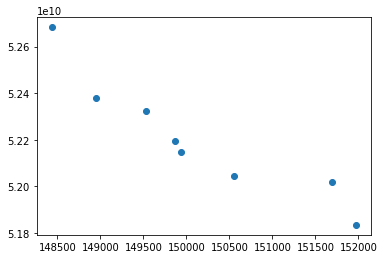

In [43]:
from utils.calc_pareto import get_pareto_undominated_by

front = get_pareto_undominated_by(np.array([[x[0],x[1]] for x in zip(mae,mse)]))

plt.scatter(front[:,0],front[:,1])

In [45]:
front

array([[1.48947562e+05, 5.23794336e+10],
       [1.48434456e+05, 5.26830004e+10],
       [1.51974196e+05, 5.18343623e+10],
       [1.49529263e+05, 5.23217936e+10],
       [1.51689287e+05, 5.20190901e+10],
       [1.49940321e+05, 5.21453359e+10],
       [1.50555827e+05, 5.20444252e+10],
       [1.49865986e+05, 5.21936596e+10]])

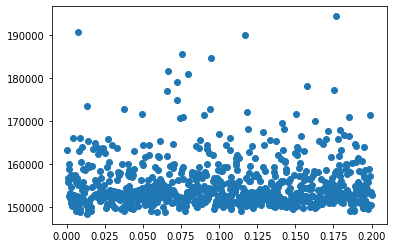

In [44]:
plt.scatter(evs, mae)

In [5]:
mae

[542668.6600411241,
 158561.60495737664,
 542668.6600411241,
 153747.38450240827,
 151261.23043662182,
 154111.52223269362,
 149556.92762861977,
 158932.8808901645,
 152480.40333169122,
 152758.2764254198,
 150204.70931770475,
 156674.5767782942,
 153009.96851439343,
 164565.18173834818,
 163059.0111217015]

In [9]:
results

[[0.0, (542668.6600411241, 430043000882.53186)],
 [0.0071428571428571435, (158561.60495737664, 53805456545.73734)],
 [0.014285714285714287, (542668.6600411241, 430043000882.53186)],
 [0.02142857142857143, (153747.38450240827, 53042132030.826775)],
 [0.028571428571428574, (151261.23043662182, 53859558443.37473)],
 [0.03571428571428572, (154111.52223269362, 54473335791.36739)],
 [0.04285714285714286, (149556.92762861977, 52650535164.34418)],
 [0.05, (158932.8808901645, 56220243227.509315)],
 [0.05714285714285715, (152480.40333169122, 53227136590.350975)],
 [0.0642857142857143, (152758.2764254198, 52450070165.03605)],
 [0.07142857142857144, (150204.70931770475, 55082060711.76133)],
 [0.07857142857142858, (156674.5767782942, 56303849155.015335)],
 [0.08571428571428572, (153009.96851439343, 53740955849.229416)],
 [0.09285714285714286, (164565.18173834818, 55626798884.20249)],
 [0.1, (163059.0111217015, 55954233501.16607)]]

In [12]:
MOOnnHousesRegression(0)

C = 0
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 538371.5625 - mae: 538371.5625 - mse: 423040712704.0000 - val_loss: 542668.6250 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 538371.5000 - mae: 538371.5000 - mse: 423040843776.0000 - val_loss: 542668.6250 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 538371.2500 - mae: 538371.2500 - mse: 423040778240.0000 - val_loss: 542668.6250 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 538371.3750 - mae: 538371.3750 - mse: 423040647168.0000 - val_loss: 542668.6250 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [==============================] - 1s 2ms/step - loss: 538371.2500 - mae: 538371.2500 - mse: 423040974848.0000 - val_loss: 542668.6250 - val_mae: 542668.625

(542668.6600411241, 430043000882.53186)